In [1]:
!pip install pydicom
!pip install opencv-python
!pip install pillow # optional
!pip install pandas
!pip install tensorflow==2.15.0
!pip install tensorflow-gan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 4.8 MB/s eta 0:00:00


In [2]:
# Check that imports for the rest of the file work.
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from glob import glob
import os
import time
from datetime import date, datetime
import cv2
import string
import random
from IPython import display
import tensorflow_gan as tfgan

# Allow matplotlib images to render immediately.
%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Disable noisy outputs.

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
BASE_PATH = '/content/drive/MyDrive/Dissertation/ProstrateX/images/manifest-A3Y4AE4o5818678569166032044/PROSTATEx'

In [ ]:
image_paths = glob(os.path.join(BASE_PATH,'**/**/*ADC*'))
print(len(image_paths))

356


In [ ]:
np.save('/content/drive/MyDrive/Dissertation/ProstrateX/ADC_paths.npy', image_paths)

In [9]:
image_paths = np.load('/content/drive/MyDrive/Dissertation/ProstrateX/ADC_paths.npy')
print(len(image_paths))

356


In [13]:
def combineSlices(directory):
  files = []
  for file in glob(directory):
    if(').dcm' in file):
      continue
    files.append(pydicom.dcmread(file))

  # print("file count: {}".format(len(files)))

  # skip files with no SliceLocation (eg scout views)
  slices = []
  for f in files:
      if hasattr(f, 'SliceLocation'):
          slices.append(f)

  # ensure they are in the correct order
  slices = sorted(slices, key=lambda s: s.SliceLocation)
  # print("Slices in combination {} out of {}".format(len(slices), len(files)))
  return slices

In [11]:
findings_df = pd.read_csv('/content/drive/MyDrive/Dissertation/ProstrateX/Additional Data/ProstateX-Findings-Test.csv')
# findings_df.head()
filter = findings_df.loc[findings_df['zone'] == 'TZ'].loc[findings_df['ClinSig'] == True]
filter.tail()

,Unnamed: 0,ProxID,fid,pos,zone,ClinSig
159,495,ProstateX-0243,1,-71.67971,TZ,True
171,507,ProstateX-0252,1,21.4236 -28.9678 -4.0906,TZ,True
189,525,ProstateX-0261,1,-3.5465 -51.3759 49.5249,TZ,True
193,529,ProstateX-0263,1,8.25576 -26.6201 -37.9288,TZ,True
194,530,ProstateX-0264,1,10.9161 -29.6669 33.1635,TZ,True


In [ ]:
!pip install pypng
import png

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.7 MB/s eta 0:00:00


In [14]:
non_sig_dir = '/content/drive/MyDrive/Dissertation/MRI/Non-Significant'
sig_dir = '/content/drive/MyDrive/Dissertation/MRI/Significant'

# Array consisting of Patient IDs
patient_identifiers = [image_paths[i][101:115] for i in range(len(image_paths))]
list = []
for i, id in enumerate(patient_identifiers):
  slices = combineSlices('{}/*.dcm'.format(image_paths[i]))
  filter = findings_df.loc[findings_df['ProxID'] == id]

  temp = []
  for j, slice in enumerate(slices):
    if j > 9:
      break
    shape = slice.pixel_array.shape

    r_image = cv2.resize(np.array(slice.pixel_array),(160,160))

    # Convert to float to avoid overflow or underflow losses.
    image_2d = r_image.astype(float)

    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

    # Convert to uint
    image_2d_scaled = np.uint8(image_2d_scaled)

    temp.append(image_2d_scaled)

  list.append(np.stack(temp, axis=2))

In [15]:
resized_images_np = np.stack(list, axis=0)

In [16]:
print(resized_images_np.shape)

(356, 160, 160, 10)


In [ ]:
sig_dir = '/content/drive/MyDrive/Dissertation/MRI/Significant/'

image_paths = glob(os.path.join(sig_dir,'*'))
temp = []
print(image_paths)
for file in image_paths:
  img_filename = file.split('/')[7]
  print(img_filename)
  temp.append(img_filename)

In [ ]:
# @title Split images according to significance (Unused)

# Save findings in a dataframe
findings_df = pd.read_csv('/content/drive/MyDrive/Dissertation/ProstrateX/Additional Data/ProstateX-Findings-Test.csv')

# Array consisting of the clinical significance of each patient
clin_sig = []

# Array consisting of Patient IDs
patient_identifiers = [image_paths[i][101:115] for i in range(len(image_paths))]

# Array to save images
resized_images = []
batches = []
for i, id in enumerate(patient_identifiers):
  sig = findings_df['ClinSig'].loc[findings_dataset['ProxID'] == id]
  slices = combineSlices('{}/*.dcm'.format(image_paths[i]))
  temp = []
  if not sig.empty and bool(sig.iloc[0]):
    clin_sig.append(1)
  else:
    clin_sig.append(0)

  for j in range(len(slices)):
    if not sig.empty:
      r_image = cv2.resize(np.array(slices[j].pixel_array),(128,128))
      resized_images.append(r_image)
      if len(temp) < 8:
        temp.append(r_image)
      if bool(sig.iloc[0]):
        clin_sig.append(1)
        continue
      clin_sig.append(0)

In [17]:
training_dataset = resized_images_np
# training_dataset = normalize3DArray(resized_images_np)
# print(training_dataset[0,:,:])
# td_shape = list(training_dataset.shape)
# td_shape.append(1)
# training_dataset = np.reshape(training_dataset, td_shape)


In [18]:
today = date.today().strftime("%d-%m-%Y")
np.save('/content/drive/MyDrive/Dissertation/ProstrateX/ADC_images_resized_{}_2.npy'.format(today), resized_images_np)
# np.save('/content/drive/MyDrive/Dissertation/ProstrateX/ADC_training.npy_{}'.format(today), training_dataset)

In [3]:
training_dataset = np.load('/content/drive/MyDrive/Dissertation/ProstrateX/ADC_images_resized_16-06-2024_2.npy')

In [19]:
print(training_dataset.shape)

(356, 160, 160, 10)


In [21]:
print(training_dataset[:,:,0,0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
def getImageAttributes(slices):
  # pixel aspects, assuming all slices are the same
  ps = slices[0].PixelSpacing
  ss = slices[0].SliceThickness
  return [ps, ss]

def get3DArrayFromSlices(slices):
  # create 3D array
  img_shape = list(slices[0].pixel_array.shape)
  img_shape.append(len(slices))
  img3d = np.zeros(img_shape)

  # fill 3D array with the images from the files
  for i, s in enumerate(slices):
      img2d = s.pixel_array
      img3d[:, :, i] = img2d
  return img3d

In [22]:
def make_generator_model():
    output_shape = (160, 160, 10, 1)
    model = tf.keras.Sequential()
    initializer = tf.random_normal_initializer(0., 0.02)

    start_dim = 10  # You can adjust this depending on the desired output size
    depth = 180   # Number of filters in the first Conv3DTranspose layer

    model.add(layers.Dense(start_dim * start_dim * start_dim * depth, use_bias=False, input_shape=(160,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((start_dim, start_dim, start_dim, depth)))
    print(model.output_shape)
    assert model.output_shape == (None, start_dim, start_dim, start_dim, depth)  # Note: None is the batch size

    model.add(layers.Conv3DTranspose(64, (4, 4, 1), strides=(2, 2, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    assert model.output_shape == (None, start_dim*2, start_dim*2, start_dim, 64)


    model.add(layers.Conv3DTranspose(64, (4, 4, 1), strides=(2, 2, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    assert model.output_shape == (None, start_dim*4, start_dim*4, start_dim, 64)

    model.add(layers.Conv3DTranspose(32, (4, 4, 1), strides=(2, 2, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    assert model.output_shape == (None, start_dim*8, start_dim*8, start_dim, 32)

    # model.add(layers.Conv3DTranspose(16, (2, 2, 1), strides=(1, 1, 1), padding='same', use_bias=False))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())
    # print(model.output_shape)
    # assert model.output_shape == (None, start_dim*8, start_dim*8, start_dim*2, 16)

    # model.add(layers.Conv3DTranspose(8, (4, 4, 1), strides=(1, 1, 1), padding='same', use_bias=False))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())
    # print(model.output_shape)
    # assert model.output_shape == (None, start_dim*8, start_dim*8, start_dim, 8)

    # model.add(layers.Conv3DTranspose(4, (2, 2, 1), strides=(1, 1, 1), padding='same', use_bias=False))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())
    # print(model.output_shape)
    # assert model.output_shape == (None, start_dim*8, start_dim*8, start_dim*2, 4)

    model.add(layers.Conv3DTranspose(2, (4, 4, 2), strides=(2, 2, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    assert model.output_shape == (None, start_dim*16, start_dim*16, start_dim, 2)

    # model.add(layers.Conv2D(32, kernel_size=3, strides=(1,1), padding='valid', use_bias=False, kernel_initializer=initializer))
    # assert model.output_shape == (None, 26, 26, 32)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Conv2D(filters=3,
    #                        kernel_size=3,
    #                        strides=1,
    #                        padding='valid',
    #                        activation='tanh',
    #                        kernel_initializer=initializer))
    # assert model.output_shape == (None, 24,24,3)

    model.add(layers.Conv3DTranspose(output_shape[-1], (4, 4, 1), strides=(1, 1, 1), padding='same', use_bias=False, activation='tanh', kernel_initializer=initializer))
    print(model.output_shape)
    assert model.output_shape == (None, output_shape[0], output_shape[1], output_shape[2], output_shape[3])

    return model

generator = make_generator_model()

(None, 10, 10, 10, 180)
(None, 20, 20, 10, 64)
(None, 40, 40, 10, 64)
(None, 80, 80, 10, 32)
(None, 160, 160, 10, 2)
(None, 160, 160, 10, 1)


In [23]:
noise = tf.random.normal([1, 160])
generated_image = generator(noise, training=False)
# print(generated_image.shape)
# generate3DImage(np.array(generated_image), [1,1], 0.5)

In [24]:
print(generated_image[0,:,:,0,0])

tf.Tensor(
[[-7.54010273e-07 -1.11016061e-05  6.94685650e-06 ... -1.10573808e-06
  -7.44593990e-06  3.82852886e-06]
 [-3.69762438e-06  3.10162136e-06  8.92707158e-06 ... -3.10943938e-06
  -6.08384516e-06  1.76271882e-07]
 [-7.86176406e-06  5.89907677e-06  8.86989710e-06 ...  2.79348405e-05
   2.11682836e-05 -1.12914231e-05]
 ...
 [-1.46693208e-06 -5.63194499e-06 -7.89654678e-06 ... -6.62974417e-05
  -6.72714959e-05  1.38395872e-05]
 [ 1.04898445e-05  5.84378995e-06 -4.37599147e-06 ... -2.76567189e-05
   3.88026592e-06 -2.27234923e-05]
 [ 4.43619047e-06 -1.40162797e-06 -1.38927280e-05 ... -9.16365025e-06
  -1.73365206e-05 -1.17898821e-06]], shape=(160, 160), dtype=float32)


In [25]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv3D(1, (1, 1, 1), strides=(1, 1, 1), padding='same', input_shape=[160,160,10,1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv3D(20, (4, 4, 4), strides=(2, 2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv3D(40, (2, 2, 2), strides=(1, 1, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv3D(80, (4, 4, 4), strides=(2, 2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv3D(160, (4, 4, 4), strides=(2, 2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv3D(320, (4, 4, 4), strides=(2, 2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    # model.add(layers.Conv3D(320, (4, 4, 4), strides=(2, 2, 2), padding='same'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.3))
    # print(model.output_shape)

    # model.add(layers.Conv3D(320, (4, 4, 4), strides=(2, 2, 2), padding='same', kernel_initializer=tf.keras.initializers.HeNormal()))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.3))
    # print(model.output_shape)

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

(None, 160, 160, 10, 1)
(None, 80, 80, 5, 20)
(None, 40, 40, 3, 80)
(None, 20, 20, 2, 160)
(None, 10, 10, 1, 320)
tf.Tensor([[-7.559915e-07]], shape=(1, 1), dtype=float32)


In [26]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(8e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-5)

In [30]:
checkpoint_dir = '/content/drive/MyDrive/Dissertation/ProstrateX/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
EPOCHS = 1500
noise_dim = 160
num_examples_to_generate = 1

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed = tf.clip_by_value(seed,clip_value_min=-2.0, clip_value_max=2.0)

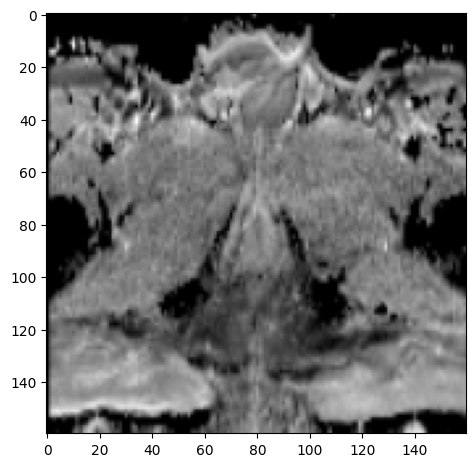

In [ ]:
# @title Preview dataset content
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(training_dataset[:,:,0,1], cmap='gray')

In [32]:
BUFFER_SIZE = training_dataset.shape[0]
BATCH_SIZE = 12
print(BUFFER_SIZE)

356


In [33]:
def normalize3DArray(array3d):
  return (array3d - 127.5)/127.5

In [34]:
# Batch and shuffle the data
x = tf.clip_by_value(resized_images_np.astype('float32'), clip_value_min=0.0, clip_value_max=255.0)
train_dataset = tf.data.Dataset.from_tensor_slices(x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset = train_dataset.map(lambda x: normalize3DArray(x))
for batch in train_dataset.as_numpy_iterator():
    print(batch.shape)

(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(12, 160, 160, 10)
(8, 160, 160, 10)


In [ ]:
# @title Setup stat functions
import tensorflow as t
import numpy as np
from scipy import linalg


def calculate_activation_statistics(images, model):
    batch_size = BATCH_SIZE
    num_images = images.shape[0]
    n_batches = int(np.ceil(num_images / batch_size))
    act = np.zeros((num_images, 2048))


    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        batch = images[start:end]
        act[start:end] = model.predict(batch)


    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)


    return mu, sigma


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    epsilon = 1e-6
    sqrtm_term = np.sqrt(np.dot(sigma1, sigma2))
    if np.iscomplexobj(sqrtm_term):
        sqrtm_term = sqrtm_term.real
    fid = np.linalg.norm(mu1 - mu2) + np.trace(sigma1 + sigma2 - 2 * sqrtm_term + epsilon)


    return fid


def calculate_fid(real_images, generated_images, model):
    real_mu, real_sigma = calculate_activation_statistics(real_images, model)
    generated_mu, generated_sigma = calculate_activation_statistics(generated_images, model)
    fid = calculate_frechet_distance(real_mu, real_sigma, generated_mu, generated_sigma)


    return fid

@tf.function
def get_inception_score(images, num_inception_images = 1):
  resized_images = tf.image.resize(images, [128, 128, 3], method=tf.image.ResizeMethod.BILINEAR)

  num_batches = BATCH_SIZE // num_inception_images
  inc_score = tfgan.eval.inception_score(resized_images, num_batches=num_batches)

  return inc_score

In [ ]:
# @title Test FID score calculator
fid_score = calculate_fid(training_dataset, training_dataset, discriminator)
print(fid_score)

1/1 [==============================] - 0s 42ms/step
-2.774387889200019


In [35]:
def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [36]:
generator_loss_arr = []
discriminator_loss_arr = []
fid_scores = []
steps = []
timestamp = int(datetime.now().timestamp())
id = id_generator()
today = date.today()
today = today.strftime("%d-%m-%Y")

In [37]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([2, noise_dim])
    noise = tf.clip_by_value(noise,clip_value_min=-2.0, clip_value_max=2.0)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)

      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [62]:
def view_images(predictions, date="", epoch=0, run_id="", save = False):
  fig = plt.figure(figsize=(20, 20))
  for i in range(predictions.shape[3]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[ 0,:, :, i] * 127.5) + 127.5, cmap='gray')
      plt.axis('off')

      if(save):
        dir = '/content/drive/MyDrive/Dissertation/ProstrateX/AugmentedImages/{}-{}-gan_images/'.format(date, run_id)
        file_name = '{}/image_at_epoch_{:04d}.png'.format(dir, epoch)
        os.makedirs(dir, exist_ok=True)
        plt.savefig(file_name)
  plt.show()

(160, 160, 10)


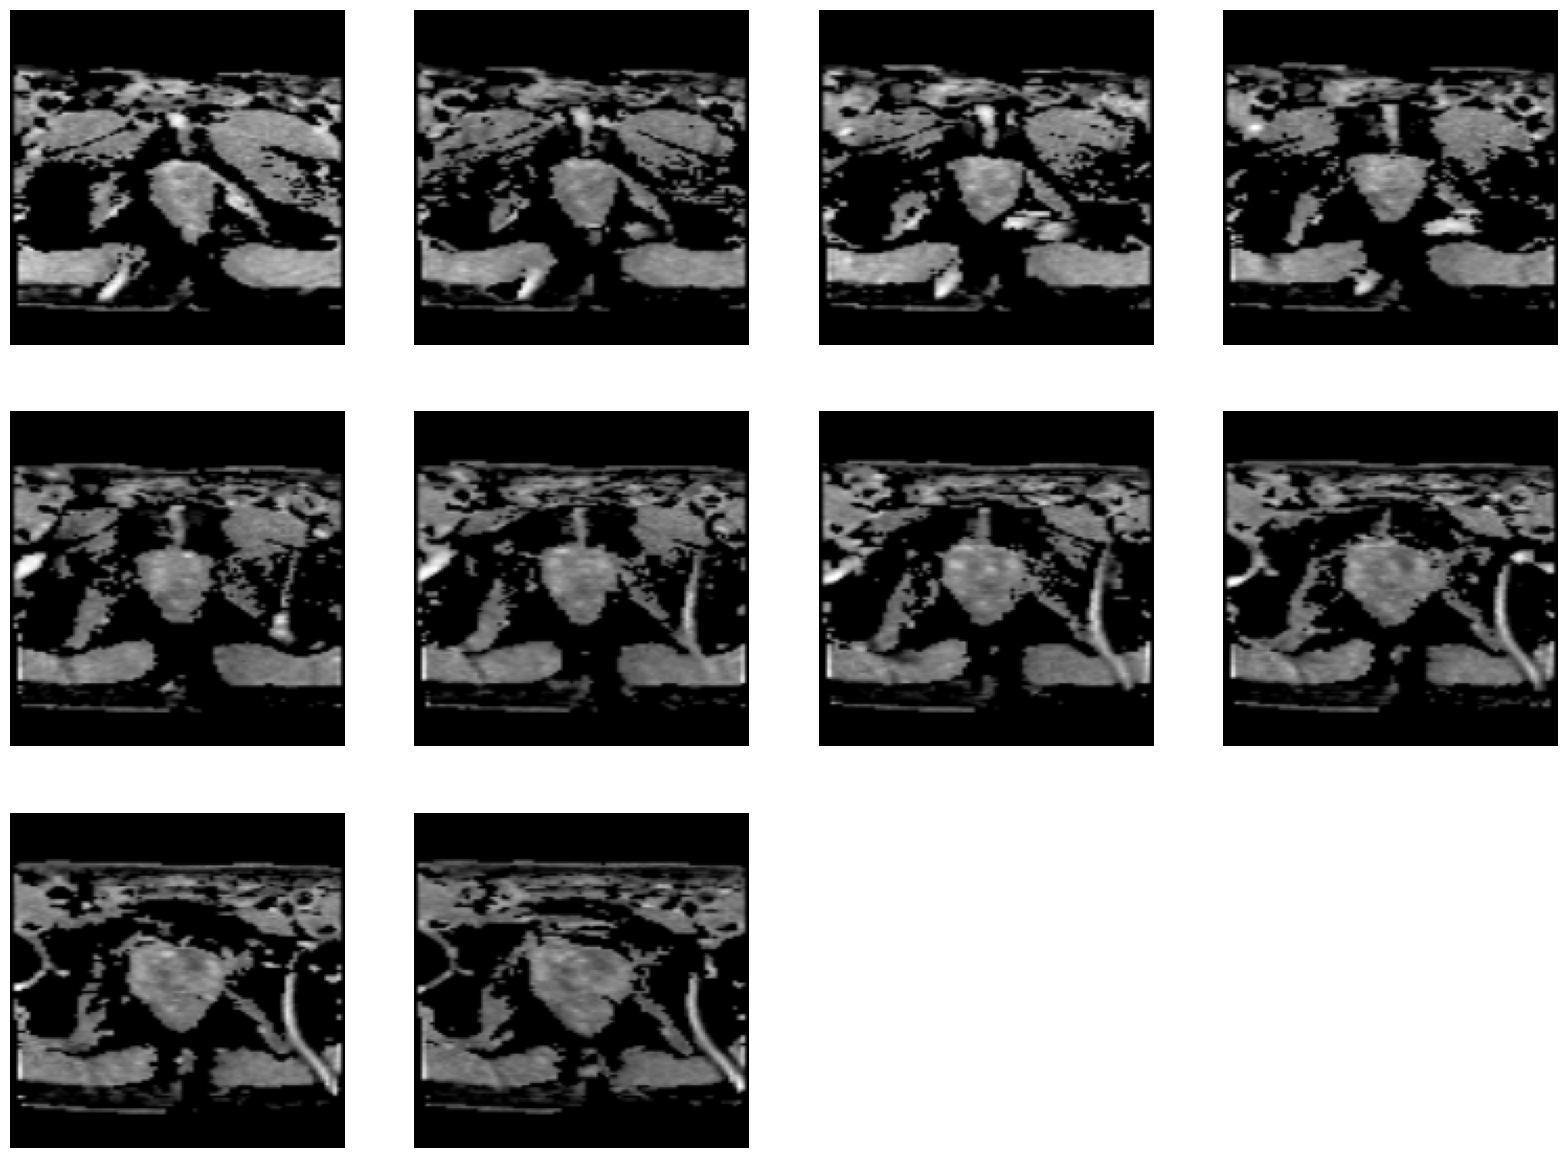

In [63]:
print(training_dataset[0].shape)
view_images(training_dataset)

In [64]:
def generate_and_save_images(model, epoch, test_input, run_id, date, timestamp):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  print(predictions.shape)
  view_images(predictions, date, epoch, run_id, True)

In [68]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      generator_loss_arr.append(tf.keras.backend.get_value(gen_loss))
      discriminator_loss_arr.append(tf.keras.backend.get_value(disc_loss))

    # Produce images
    if ((epoch + 1) % 100 == 0) and (epoch != epochs):
      img_start = time.time()
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                             epoch + 1,
                             seed, id, today, timestamp)
      print ('Time for image is {} sec'.format(time.time()-img_start))

    # Save the model every 15 epochs
    if (epoch + 1) % 500 == 0:
      print("saving checkpint")
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, id, today, timestamp)

In [52]:
image_batch = np.expand_dims(training_dataset[0,:,:,:], axis=0)

real_output = discriminator(image_batch, training=False)
print(real_output)
fake_output = discriminator(generated_image, training=False)
print(fake_output)
gen_loss = generator_loss(generated_image)
disc_loss = discriminator_loss(real_output, fake_output)
i = 0
for i,d in enumerate(train_dataset):
  if i == 1:
    break;
  x,y = train_step(d)
print(tf.keras.backend.get_value(x), tf.keras.backend.get_value(y))

tf.Tensor([[-5.363298]], shape=(1, 1), dtype=float32)
tf.Tensor([[-7.559915e-07]], shape=(1, 1), dtype=float32)
2.366127 1.4923921


(1, 160, 160, 10, 1)


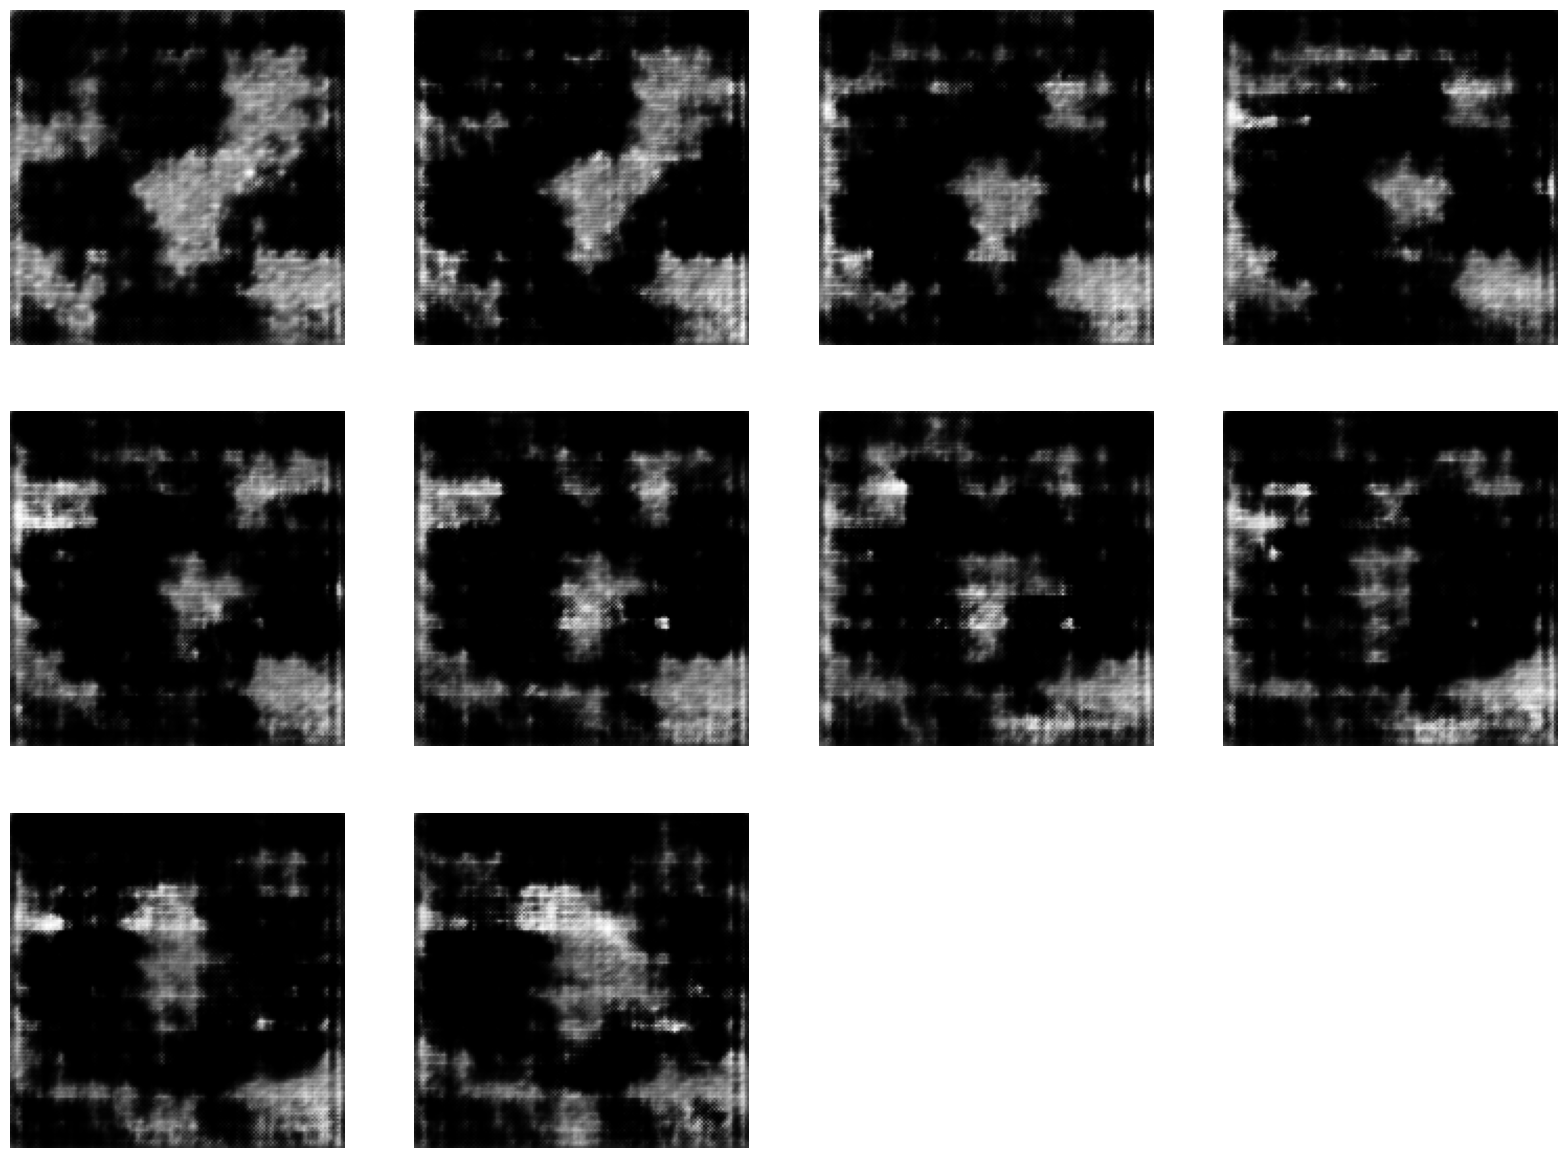

Time for image is 4.5300586223602295 sec
Time for epoch 100 is 5.284801721572876 sec
Time for epoch 101 is 0.7915408611297607 sec
Time for epoch 102 is 0.754326343536377 sec
Time for epoch 103 is 0.7417292594909668 sec
Time for epoch 104 is 0.7456800937652588 sec
Time for epoch 105 is 0.7516195774078369 sec
Time for epoch 106 is 0.747260332107544 sec
Time for epoch 107 is 0.7531154155731201 sec
Time for epoch 108 is 0.7455339431762695 sec
Time for epoch 109 is 0.7458014488220215 sec
Time for epoch 110 is 0.7535181045532227 sec
Time for epoch 111 is 0.7558374404907227 sec
Time for epoch 112 is 0.7458899021148682 sec
Time for epoch 113 is 0.754406213760376 sec


In [ ]:
train(train_dataset, EPOCHS)


In [ ]:
# np.save('/content/drive/MyDrive/Dissertation/ProstrateX/fid_scores_{}_{}_{}'.format(today, id, timestamp), fid_scores)
np.save('/content/drive/MyDrive/Dissertation/ProstrateX/generator_loss_{}_{}_{}'.format(today, id, timestamp), generator_loss_arr)
np.save('/content/drive/MyDrive/Dissertation/ProstrateX/discriminator_loss_{}_{}_{}'.format(today, id, timestamp), discriminator_loss_arr)
np.save('/content/drive/MyDrive/Dissertation/ProstrateX/steps_{}_{}_{}'.format(today, id, timestamp), steps)

In [ ]:
generator_loss_arr[0]

<tf.Tensor 'binary_crossentropy/weighted_loss/value:0' shape=() dtype=float32>

In [ ]:
plt.title('Generator loss per step')
plt.plot(steps, discriminator_loss_arr)
plt.figure()

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
x = make_generator_model()
x.load_weights(latest)

(None, 10, 10, 10, 180)
(None, 20, 20, 10, 64)
(None, 40, 40, 10, 64)
(None, 80, 80, 10, 2)
(None, 160, 160, 10, 1)


AssertionError: Nothing except the root object matched a checkpointed value. Typically this means that the checkpoint does not match the Python program. The following objects have no matching checkpointed value: [<tf.Variable 'dense_169/kernel:0' shape=(160, 180000) dtype=float32, numpy=
array([[-4.0721367e-03,  8.2219997e-04, -2.2101740e-03, ...,
        -4.1468288e-03, -3.3373213e-03,  5.5570593e-03],
       [-5.2720704e-03,  3.1065457e-03,  4.2029656e-03, ...,
         1.4627352e-05,  4.7318926e-03,  3.1062476e-03],
       [ 4.9017640e-03, -5.1620137e-04, -1.4136359e-03, ...,
         1.1650617e-03,  5.7814457e-04,  3.5068542e-03],
       ...,
       [-2.8608723e-03, -4.7756601e-03,  3.4255525e-03, ...,
         5.6968322e-03,  8.1275590e-04, -3.1757122e-04],
       [-5.2367346e-03,  1.8057558e-03,  5.4681115e-03, ...,
        -1.8030950e-03, -2.7257670e-04, -3.0592838e-03],
       [-5.1805167e-03, -1.9151252e-05, -2.2811703e-03, ...,
        -9.7050145e-04,  5.5008754e-03,  3.3747964e-03]], dtype=float32)>, <tf.Variable 'batch_normalization_437/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'conv3d_transpose_176/kernel:0' shape=(4, 4, 2, 2, 64) dtype=float32, numpy=
array([[[[[ 0.0463237 , -0.04926052, -0.00352355, ...,  0.00730854,
            0.05319525, -0.02243959],
          [ 0.04588266,  0.00562876,  0.04428488, ..., -0.04117259,
            0.02662128, -0.04566894]],

         [[ 0.00448857,  0.01945628, -0.02710612, ..., -0.00252492,
           -0.05084382, -0.02552857],
          [ 0.04950244, -0.03885034, -0.04908922, ..., -0.04073961,
            0.01834254,  0.0353772 ]]],


        [[[ 0.04567944,  0.00891074, -0.04120577, ..., -0.00199982,
            0.03184606, -0.04207633],
          [ 0.05143242,  0.01856118,  0.04243582, ..., -0.03350271,
           -0.04812614, -0.03932034]],

         [[-0.02749153,  0.02802484, -0.01240835, ..., -0.03076827,
           -0.03851558,  0.03782609],
          [ 0.02638752,  0.0231131 , -0.05082482, ...,  0.02154323,
           -0.01506044, -0.02882744]]],


        [[[-0.04643665, -0.04342798,  0.01888757, ..., -0.03646559,
            0.01382128, -0.0419707 ],
          [-0.05283161,  0.01718032, -0.02961931, ..., -0.03887316,
           -0.01881443, -0.0399889 ]],

         [[ 0.00443605, -0.05073284,  0.02215254, ...,  0.01580144,
           -0.04854292, -0.00796361],
          [ 0.04796428, -0.01175914, -0.05216374, ..., -0.00323931,
            0.00236143, -0.02572399]]],


        [[[-0.01376456,  0.01350791, -0.03589183, ...,  0.03257032,
           -0.04007584,  0.02977265],
          [ 0.02816747,  0.01086459,  0.02727003, ...,  0.03499436,
           -0.00048843, -0.03170081]],

         [[ 0.00270972, -0.00141684, -0.05115094, ..., -0.03840615,
            0.05211537, -0.02656349],
          [ 0.0453561 , -0.0156667 ,  0.01808704, ...,  0.04446711,
           -0.01332412, -0.0047892 ]]]],



       [[[[-0.01211971,  0.01608337, -0.0143673 , ..., -0.0268121 ,
           -0.00313409,  0.04895746],
          [ 0.02620181,  0.01898165,  0.0213232 , ...,  0.03087999,
            0.04781748, -0.02318471]],

         [[-0.05266686,  0.04824412,  0.02546536, ...,  0.03709801,
            0.02371038,  0.04883487],
          [-0.04230507, -0.04268295, -0.02896858, ...,  0.0369192 ,
           -0.03367876, -0.01430014]]],


        [[[-0.02797738,  0.04922253,  0.00364636, ...,  0.03100623,
            0.04465539, -0.01437336],
          [-0.03521053,  0.03740555,  0.04847588, ..., -0.02370843,
           -0.01961547,  0.01936647]],

         [[ 0.0278756 , -0.01619399, -0.013503  , ..., -0.01273693,
            0.03728303, -0.00929257],
          [-0.05249729,  0.03646401,  0.01283284, ...,  0.0483689 ,
           -0.0063411 ,  0.04083949]]],


        [[[ 0.00353245,  0.01781228,  0.05302133, ..., -0.01261257,
            0.031064  , -0.04683888],
          [ 0.05229244, -0.03519154,  0.00081797, ...,  0.00507379,
           -0.04766721,  0.00873772]],

         [[-0.03357414,  0.04364859,  0.01167396, ..., -0.03566538,
           -0.02405435,  0.04651398],
          [-0.05236764, -0.01918625, -0.03167255, ...,  0.02845892,
            0.02353449, -0.03760108]]],


        [[[-0.01913917,  0.02703317, -0.04575695, ..., -0.04920625,
            0.02272196, -0.03269875],
          [ 0.04952773,  0.02119305, -0.03248639, ..., -0.01512276,
            0.00022366, -0.01930524]],

         [[ 0.00352553, -0.01011932,  0.00252027, ...,  0.01764148,
            0.0153761 ,  0.01260006],
          [ 0.00179012, -0.00648572,  0.0431323 , ...,  0.02795801,
            0.02524475, -0.00243099]]]],



       [[[[ 0.01395115,  0.01954181, -0.02018206, ...,  0.05121379,
           -0.01452426,  0.03340698],
          [ 0.05105044,  0.03342167,  0.00669757, ...,  0.00217939,
           -0.03709129, -0.0435649 ]],

         [[ 0.04108091, -0.00699969,  0.02095624, ...,  0.01430088,
           -0.04723806,  0.03552835],
          [ 0.02237486, -0.02530011, -0.04542106, ...,  0.04065751,
            0.00699689,  0.02225202]]],


        [[[-0.03254026,  0.03182953, -0.05011966, ...,  0.03951103,
            0.01531549,  0.04365382],
          [ 0.03778099,  0.03489959, -0.00479405, ...,  0.05108075,
            0.03351596, -0.05208144]],

         [[-0.0289728 ,  0.02008459, -0.03808535, ..., -0.01306478,
           -0.01439363, -0.01305692],
          [ 0.00608363, -0.04282364,  0.00402753, ..., -0.02567072,
            0.04712004,  0.03366102]]],


        [[[ 0.02409029,  0.03305595,  0.00519102, ...,  0.03424428,
           -0.03952414,  0.0501222 ],
          [ 0.01971827,  0.05117674,  0.04351933, ...,  0.05292371,
           -0.0151239 ,  0.01208341]],

         [[-0.00487877, -0.04122694,  0.053189  , ..., -0.02321522,
            0.03012256,  0.05179331],
          [-0.01599078, -0.0395028 ,  0.04296778, ..., -0.00625596,
           -0.04112054, -0.00470104]]],


        [[[-0.0363022 ,  0.04527058,  0.02630503, ...,  0.02195197,
            0.01363084,  0.04662454],
          [-0.0086834 , -0.01971373, -0.05090772, ...,  0.05303162,
            0.00973252,  0.03490291]],

         [[ 0.02570538, -0.03272235,  0.04123015, ...,  0.02444915,
           -0.01840811,  0.04718395],
          [ 0.00663289, -0.00827084, -0.01118594, ...,  0.02354794,
            0.02200195, -0.0147633 ]]]],



       [[[[-0.02187069,  0.00703252,  0.00705579, ...,  0.01749076,
            0.05150326, -0.00893907],
          [ 0.01508232,  0.0300405 ,  0.03509617, ...,  0.02631447,
           -0.01680049, -0.04515477]],

         [[-0.00283985,  0.04499377,  0.03789219, ..., -0.04655021,
            0.01071612, -0.02552173],
          [ 0.02830379, -0.04114388,  0.04389472, ...,  0.01720572,
           -0.01581696,  0.02371741]]],


        [[[-0.01383845,  0.02989404, -0.00371467, ...,  0.04570591,
           -0.01303911,  0.00767064],
          [-0.00525143, -0.02547394, -0.00505888, ...,  0.00980294,
           -0.01048797, -0.02606234]],

         [[-0.00735005, -0.04790978, -0.01927293, ..., -0.04751132,
            0.0034774 ,  0.02990215],
          [-0.01073256,  0.00221468,  0.04145852, ...,  0.0493243 ,
           -0.0237804 ,  0.00084546]]],


        [[[ 0.03523261, -0.00094238,  0.01525341, ...,  0.02047632,
            0.01538285,  0.02030388],
          [ 0.0128024 , -0.01534322, -0.00758998, ..., -0.03326381,
            0.00810471, -0.00996397]],

         [[-0.03473078,  0.01686061,  0.01957904, ..., -0.04973849,
           -0.05111247, -0.03617226],
          [-0.05145195, -0.04544431, -0.00912195, ..., -0.01868605,
            0.01358832,  0.00629457]]],


        [[[-0.03053461,  0.02892827, -0.0159963 , ...,  0.04064845,
            0.0013508 , -0.02808814],
          [-0.00288331, -0.01091033, -0.03540662, ..., -0.04106894,
           -0.03173627,  0.00646851]],

         [[ 0.03785884, -0.02386272,  0.00278063, ..., -0.0088494 ,
           -0.03782658, -0.04524228],
          [ 0.04595249,  0.04518223,  0.02182303, ...,  0.03416964,
           -0.02529111, -0.02832441]]]]], dtype=float32)>, <tf.Variable 'batch_normalization_438/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'batch_normalization_437/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'batch_normalization_439/moving_variance:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>, <tf.Variable 'batch_normalization_436/moving_variance:0' shape=(180000,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Variable 'batch_normalization_437/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'batch_normalization_436/beta:0' shape=(180000,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, <tf.Variable 'conv3d_transpose_175/kernel:0' shape=(4, 4, 1, 64, 64) dtype=float32, numpy=
array([[[[[ 0.0292285 , -0.04510751, -0.05011333, ..., -0.04411033,
            0.02730409,  0.03697507],
          [ 0.05394972,  0.01807919,  0.04765398, ..., -0.01746592,
            0.03755813, -0.01742443],
          [-0.02624389, -0.00931576, -0.0272276 , ...,  0.01603529,
            0.00502205, -0.01510515],
          ...,
          [ 0.03289839, -0.01726508, -0.0455758 , ...,  0.025505  ,
           -0.02307285, -0.04908838],
          [-0.04327804,  0.04352089, -0.02447236, ...,  0.01437229,
           -0.00160472, -0.01721533],
          [ 0.03716326, -0.01266766,  0.00291815, ...,  0.04101107,
            0.03920719,  0.04262536]]],


        [[[ 0.03633679,  0.03914163,  0.04637888, ..., -0.0186415 ,
           -0.03220621, -0.02829632],
          [-0.03601307,  0.05167864, -0.04636084, ..., -0.0421007 ,
            0.04466927, -0.04995433],
          [-0.0337078 , -0.03775084, -0.00070046, ...,  0.02720738,
            0.00362036,  0.01795276],
          ...,
          [ 0.01382716, -0.02255356,  0.03645933, ..., -0.05304874,
            0.0423818 ,  0.01950032],
          [ 0.01801979,  0.03325307,  0.03788278, ..., -0.01316734,
           -0.02635198,  0.004138  ],
          [ 0.01999596, -0.02798423,  0.01423961, ...,  0.00060314,
            0.0538925 ,  0.04323003]]],


        [[[-0.00963926,  0.03474385, -0.01528969, ...,  0.04635159,
            0.04307768, -0.02736408],
          [ 0.03239853, -0.03046047, -0.04944965, ..., -0.00887124,
           -0.01753797, -0.03901948],
          [-0.02762949, -0.01181545, -0.01345552, ...,  0.03209216,
            0.04171008,  0.00337172],
          ...,
          [-0.02140576, -0.03027074,  0.00744201, ..., -0.00147294,
            0.00184159, -0.00542127],
          [ 0.03355446, -0.03419876,  0.0109033 , ..., -0.01080829,
           -0.04664639,  0.04529671],
          [-0.01170119,  0.00036564,  0.01978547, ..., -0.03517372,
           -0.00817905,  0.05129478]]],


        [[[-0.00875686,  0.0156736 , -0.01892709, ...,  0.00226961,
           -0.05147836, -0.05148631],
          [ 0.02790504,  0.05323303, -0.00849047, ...,  0.01106289,
            0.00500244, -0.0428526 ],
          [ 0.0332903 ,  0.05306217, -0.04112809, ...,  0.02151558,
           -0.04831323,  0.01095144],
          ...,
          [ 0.00521818, -0.00158797, -0.0005723 , ..., -0.01225331,
            0.0411293 , -0.03283583],
          [ 0.02394155, -0.05188416, -0.01531905, ..., -0.05064659,
           -0.00740793,  0.01484285],
          [ 0.01572916, -0.01764754, -0.01590576, ...,  0.01881592,
            0.04289534, -0.01358627]]]],



       [[[[-0.02671957, -0.01140637, -0.01156185, ..., -0.02831507,
           -0.03853309, -0.0515016 ],
          [ 0.04562539, -0.05391219, -0.04475689, ..., -0.05184639,
           -0.00927896,  0.04934945],
          [ 0.00967479,  0.03418983, -0.00709683, ..., -0.04949995,
            0.0343081 ,  0.02373336],
          ...,
          [ 0.01929596, -0.03103842,  0.0525473 , ...,  0.0166274 ,
           -0.00604157, -0.01226542],
          [-0.05228879,  0.015227  ,  0.0371868 , ..., -0.0484659 ,
            0.00818107, -0.04167396],
          [-0.01399472, -0.04527167, -0.03963457, ...,  0.01404656,
           -0.0044633 , -0.01363783]]],


        [[[-0.01840685,  0.00571119,  0.00446992, ...,  0.00767753,
           -0.05218527, -0.02991994],
          [-0.03457094,  0.0407253 ,  0.03126814, ...,  0.02819858,
            0.00232688,  0.03780846],
          [ 0.01068628,  0.02228231,  0.00815892, ...,  0.00639866,
           -0.01614797, -0.02806418],
          ...,
          [-0.01722484, -0.04011013, -0.00203981, ...,  0.02331502,
            0.05339378,  0.00256369],
          [ 0.00814589,  0.05081676, -0.02383057, ..., -0.04969487,
           -0.03155766,  0.01639727],
          [-0.01069522, -0.00840376, -0.05221185, ...,  0.0405875 ,
           -0.04023513,  0.00841312]]],


        [[[ 0.03913969,  0.01149428,  0.03195075, ...,  0.02299457,
            0.00269638,  0.01303747],
          [ 0.02702077,  0.03110915, -0.00186193, ...,  0.03036031,
           -0.0018237 , -0.00810251],
          [-0.03298677,  0.01291632,  0.03072686, ...,  0.0308628 ,
           -0.00509259, -0.0241232 ],
          ...,
          [-0.02488592,  0.0100993 ,  0.01355336, ...,  0.01023458,
            0.05163802,  0.0002257 ],
          [ 0.04836446,  0.00619968, -0.00430094, ..., -0.04298291,
           -0.03938245,  0.00636965],
          [ 0.04885106, -0.02727852,  0.0451727 , ..., -0.04049899,
           -0.01292448,  0.00606048]]],


        [[[ 0.01851905, -0.0196265 , -0.0104918 , ..., -0.02697375,
           -0.04629172, -0.01993278],
          [-0.04897586, -0.03615246, -0.00614616, ..., -0.05085864,
            0.02651435,  0.03740421],
          [-0.02271776,  0.03714703, -0.01506677, ..., -0.03462858,
           -0.00200611, -0.05056727],
          ...,
          [ 0.01923155, -0.02603869,  0.04597343, ..., -0.01738992,
            0.03009881,  0.025623  ],
          [-0.00114006,  0.01650211,  0.01408198, ..., -0.01631234,
            0.03133527, -0.0378381 ],
          [ 0.02555916, -0.02756587, -0.01375109, ..., -0.03261457,
           -0.01933153,  0.0462769 ]]]],



       [[[[-0.04390179,  0.00631972,  0.00842677, ..., -0.01064145,
            0.00865316,  0.01922019],
          [ 0.03660952, -0.01550022,  0.03088887, ...,  0.02538178,
           -0.00794068,  0.01652374],
          [ 0.04977503,  0.00507512, -0.01785329, ..., -0.0004507 ,
            0.01475653, -0.00506413],
          ...,
          [ 0.04083518,  0.0266229 , -0.00189427, ..., -0.03219265,
            0.03485181, -0.00114006],
          [-0.05210003, -0.01001922,  0.02945816, ..., -0.04258793,
            0.01948952,  0.03860116],
          [ 0.03381345, -0.02924419,  0.01087978, ...,  0.03719769,
           -0.04833375,  0.020356  ]]],


        [[[ 0.02499546, -0.00764065, -0.0011422 , ..., -0.02696642,
            0.05008429,  0.0231558 ],
          [ 0.00908911,  0.02644859,  0.04111145, ..., -0.00067886,
           -0.02841024, -0.05159353],
          [-0.01744439, -0.01599952, -0.03249483, ...,  0.00386208,
            0.04907955, -0.01851857],
          ...,
          [-0.04110636, -0.00611567, -0.00065533, ..., -0.02151889,
           -0.01118302,  0.04705932],
          [-0.04101706,  0.02734457, -0.01063389, ..., -0.05138526,
           -0.04900486,  0.0272149 ],
          [-0.01845242, -0.00680104, -0.0410639 , ...,  0.02588583,
           -0.05249737, -0.05365018]]],


        [[[-0.048829  , -0.03363746,  0.01063926, ..., -0.04541247,
           -0.03279231,  0.01645534],
          [ 0.01447856, -0.01191241, -0.03082528, ..., -0.04350036,
           -0.04701735,  0.03244136],
          [-0.01312379, -0.03921548,  0.036526  , ..., -0.00877305,
           -0.00017776,  0.01133696],
          ...,
          [ 0.04857804, -0.0081602 , -0.03493952, ..., -0.04417748,
           -0.01721751,  0.02730763],
          [ 0.03504329,  0.04767684,  0.01384301, ...,  0.00115323,
           -0.03964667,  0.04895532],
          [-0.03535993,  0.04459576, -0.02058215, ...,  0.02463112,
           -0.02047376,  0.02380051]]],


        [[[-0.04249132, -0.02502827,  0.04248481, ..., -0.0118039 ,
           -0.00778455,  0.02829256],
          [ 0.0060969 , -0.0101369 , -0.03910954, ...,  0.0485248 ,
           -0.00721163, -0.02809059],
          [-0.03609882, -0.02962432, -0.0184776 , ..., -0.02068263,
           -0.00029919,  0.02879682],
          ...,
          [ 0.01955224,  0.02083759, -0.03811202, ..., -0.05057031,
            0.01114382, -0.03143109],
          [-0.03728832, -0.01773207,  0.00324855, ...,  0.01121041,
            0.05181788,  0.05072967],
          [-0.02189312,  0.05250621, -0.04155437, ...,  0.01616114,
            0.04389609,  0.00432102]]]],



       [[[[-0.01608096,  0.01577489, -0.03659153, ...,  0.04359913,
            0.02341265,  0.03497496],
          [ 0.04732421,  0.02443618, -0.04530822, ...,  0.04245612,
            0.03055659,  0.01340623],
          [-0.02298764, -0.04585341,  0.0028593 , ..., -0.02144744,
           -0.03934219,  0.02478446],
          ...,
          [-0.03457005,  0.03689532, -0.03326262, ...,  0.03374359,
           -0.04430974, -0.04354661],
          [-0.04148692,  0.00403531,  0.03247573, ...,  0.03010427,
            0.03774634, -0.01379488],
          [ 0.030096  ,  0.04855682, -0.00711135, ..., -0.04258292,
           -0.02434924,  0.0347731 ]]],


        [[[ 0.01634108,  0.01506447,  0.04506344, ...,  0.00725543,
           -0.05131797, -0.02316517],
          [ 0.04605607,  0.01161501, -0.04115621, ..., -0.04296885,
            0.01681198,  0.01791247],
          [ 0.03345671, -0.05229172,  0.03568582, ..., -0.03638855,
            0.01044079,  0.05073157],
          ...,
          [ 0.00068749,  0.00897115, -0.04993243, ..., -0.05116717,
           -0.01864197,  0.00949389],
          [ 0.01339261,  0.02367105, -0.04772123, ..., -0.04545687,
            0.02417613, -0.03039833],
          [-0.02310153, -0.00685452,  0.02434867, ...,  0.03399331,
            0.00521431, -0.01185244]]],


        [[[-0.03202428,  0.03022571,  0.02425139, ..., -0.03266846,
           -0.05046425,  0.03059879],
          [-0.05203102,  0.04124674, -0.04263993, ...,  0.01717801,
           -0.01552507, -0.02001425],
          [ 0.0452738 , -0.01957452, -0.05055479, ...,  0.02877196,
           -0.01103418,  0.05259845],
          ...,
          [-0.00670076,  0.04432187,  0.01848222, ...,  0.03850647,
            0.00390535, -0.02950907],
          [-0.01483564,  0.02532888,  0.02786152, ...,  0.01506775,
            0.05116814,  0.03086997],
          [-0.01023197, -0.02040876, -0.01699101, ..., -0.01102185,
           -0.0319479 , -0.03222393]]],


        [[[-0.03962854, -0.03509934,  0.00241394, ...,  0.01532531,
           -0.05390673,  0.00419895],
          [-0.03155036,  0.00982955, -0.04994521, ...,  0.03651632,
           -0.0050129 , -0.01279588],
          [-0.00026435, -0.03433589, -0.03041537, ..., -0.00842316,
            0.00219838, -0.0212476 ],
          ...,
          [ 0.0196517 ,  0.02842728, -0.03276442, ..., -0.05257285,
           -0.03875761, -0.00175124],
          [ 0.02958868,  0.01902632,  0.03938802, ...,  0.04185747,
           -0.01662241, -0.00231423],
          [ 0.04774549, -0.03233696,  0.01140131, ...,  0.00942126,
            0.01006989,  0.00627729]]]]], dtype=float32)>, <tf.Variable 'batch_normalization_437/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'batch_normalization_438/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'batch_normalization_438/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'batch_normalization_439/beta:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>, <tf.Variable 'batch_normalization_436/gamma:0' shape=(180000,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Variable 'conv3d_transpose_177/kernel:0' shape=(4, 4, 1, 1, 2) dtype=float32, numpy=
array([[[[[ 0.037722  ,  0.02257242]]],


        [[[ 0.02409947, -0.04137445]]],


        [[[-0.01083605, -0.02489035]]],


        [[[-0.00417902,  0.00155948]]]],



       [[[[ 0.02397021, -0.01499963]]],


        [[[-0.04647746,  0.00823955]]],


        [[[-0.00411809,  0.00963333]]],


        [[[-0.01951445, -0.00824296]]]],



       [[[[ 0.0197657 , -0.00954128]]],


        [[[ 0.03980253, -0.00410464]]],


        [[[-0.04959192,  0.01904097]]],


        [[[-0.00620851, -0.00664651]]]],



       [[[[-0.01418758,  0.0040057 ]]],


        [[[ 0.00089875,  0.03780781]]],


        [[[ 0.00205187, -0.02135517]]],


        [[[-0.01522284,  0.01917692]]]]], dtype=float32)>, <tf.Variable 'batch_normalization_438/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'conv3d_transpose_174/kernel:0' shape=(4, 4, 1, 64, 180) dtype=float32, numpy=
array([[[[[-3.30225229e-02, -2.63759531e-02,  1.97354741e-02, ...,
           -3.64185125e-03,  3.03521305e-02, -2.67050043e-03],
          [-1.61075797e-02,  2.96880752e-02, -1.81301143e-02, ...,
           -2.77282223e-02,  2.89524868e-02,  3.10148150e-02],
          [ 3.97280231e-03, -2.70221028e-02,  1.78024471e-02, ...,
            2.19285227e-02,  2.74270326e-02, -3.67473178e-02],
          ...,
          [ 3.32419202e-02, -1.66026596e-02,  5.88570908e-03, ...,
            8.54760408e-04,  2.36197710e-02, -1.26794707e-02],
          [ 3.85661647e-02, -5.47190011e-03,  1.38827451e-02, ...,
            1.89842768e-02, -3.30803506e-02, -2.09521148e-02],
          [ 6.90652430e-03, -1.02253687e-02,  1.73458084e-02, ...,
           -3.53406668e-02, -8.08054954e-03,  1.53859183e-02]]],


        [[[ 3.66209894e-02,  3.08597013e-02,  3.62367928e-03, ...,
            3.75448540e-02, -2.88937911e-02,  7.51021877e-03],
          [-2.61588097e-02, -3.28716487e-02,  2.65399143e-02, ...,
            3.60123813e-03, -8.56837630e-03, -1.92012340e-02],
          [-6.47915155e-03, -7.96341524e-03,  3.37655917e-02, ...,
            1.05898157e-02,  1.66851617e-02, -5.89811057e-03],
          ...,
          [ 3.81178781e-02, -8.20711441e-03, -2.64475495e-02, ...,
           -3.69292796e-02,  4.34366241e-03, -1.30038783e-02],
          [ 2.29153782e-04, -1.76542532e-02,  1.29266456e-02, ...,
            2.08235681e-02,  1.97023340e-02,  1.39767900e-02],
          [-7.31582567e-03, -1.54239964e-02, -2.78519168e-02, ...,
            8.76734778e-03, -3.31818089e-02,  1.37942284e-02]]],


        [[[-3.60521711e-02,  3.64816710e-02, -3.75993289e-02, ...,
           -2.82027759e-02, -3.53516862e-02,  2.67819017e-02],
          [ 2.89745405e-02, -7.21473247e-03, -3.41006443e-02, ...,
            3.86604965e-02,  2.57672891e-02,  1.35678127e-02],
          [-3.39789763e-02, -2.33341251e-02, -2.12514400e-03, ...,
           -3.23983841e-02, -1.42784473e-02,  1.83170512e-02],
          ...,
          [ 2.44343504e-02,  1.53555386e-02,  3.52507904e-02, ...,
            2.85811722e-02, -1.31111126e-02, -1.84486713e-02],
          [-1.64336339e-03,  3.91038284e-02,  1.62937120e-03, ...,
           -2.58523934e-02,  5.01924381e-03,  3.46805379e-02],
          [ 6.56676665e-03, -2.81081870e-02, -1.35297738e-02, ...,
            1.67776011e-02,  1.10718459e-02,  1.66724771e-02]]],


        [[[-3.25237513e-02,  3.44743431e-02, -3.79602350e-02, ...,
           -6.85801357e-03,  2.40063220e-02, -3.36700678e-02],
          [-2.32998133e-02,  2.38103122e-02, -3.04803457e-02, ...,
            3.34939882e-02, -9.43138078e-03, -1.96453165e-02],
          [ 3.06211188e-02, -9.81296971e-03, -8.87135044e-03, ...,
           -1.51600521e-02,  3.38240340e-02,  2.64999270e-03],
          ...,
          [ 2.70974785e-02, -3.11562940e-02,  4.29898500e-06, ...,
            1.48424767e-02, -1.14241634e-02, -2.09274292e-02],
          [-1.59357488e-03,  2.40648240e-02, -2.23914776e-02, ...,
           -3.88682075e-02,  2.20145881e-02, -7.34224916e-04],
          [-5.66010550e-03,  1.39493197e-02, -2.52030566e-02, ...,
            2.75563747e-02, -1.18844919e-02,  5.29571250e-03]]]],



       [[[[ 3.42267379e-02, -9.41391103e-03,  2.50961930e-02, ...,
            2.59137899e-03, -2.42526121e-02,  1.35975294e-02],
          [-5.37661836e-03,  3.85410041e-02, -2.45423149e-02, ...,
           -3.65168713e-02, -2.79465169e-02, -3.45546603e-02],
          [ 9.36417654e-03, -3.42082977e-02,  1.13159493e-02, ...,
            3.51286083e-02,  3.25655788e-02, -1.28656588e-02],
          ...,
          [ 3.49241868e-02,  3.40757445e-02,  6.75204769e-03, ...,
           -8.03186186e-03,  9.96817276e-03,  9.16160643e-05],
          [ 1.10505894e-03, -3.57439816e-02,  2.09408067e-02, ...,
            1.97842084e-02, -2.19246075e-02,  2.98813954e-02],
          [ 3.49420011e-02,  4.57512587e-03,  1.25774890e-02, ...,
            1.46330148e-03,  2.47974098e-02,  2.15820670e-02]]],


        [[[-2.54488010e-02, -1.12706795e-03, -2.88126618e-02, ...,
           -2.75788233e-02, -1.90961026e-02,  2.56445482e-02],
          [ 8.13453645e-03,  1.29428431e-02,  2.26642452e-02, ...,
           -2.21638102e-02, -1.05948914e-02,  3.49789262e-02],
          [-1.65409148e-02,  3.18829045e-02,  2.48897448e-02, ...,
            2.81286538e-02,  2.45342851e-02, -2.73354799e-02],
          ...,
          [ 5.87269664e-03,  3.84740084e-02,  1.57642812e-02, ...,
            3.51671726e-02, -1.31673366e-03,  2.44127214e-02],
          [ 2.41329819e-02, -3.79029028e-02,  1.70127563e-02, ...,
           -3.40232514e-02,  2.25437656e-02,  1.88640393e-02],
          [ 2.99473926e-02,  1.65229961e-02, -2.03159470e-02, ...,
           -2.27685161e-02, -2.02074964e-02, -7.05601275e-03]]],


        [[[ 1.08563751e-02,  5.61504439e-03, -2.37607211e-02, ...,
            1.58406049e-03,  2.73024887e-02,  1.81118138e-02],
          [-2.47199088e-03,  5.68344444e-03,  2.11736411e-02, ...,
            1.49426572e-02,  9.35915858e-03,  1.49877556e-02],
          [ 1.93532035e-02,  1.24507546e-02, -7.35899061e-03, ...,
           -1.96864810e-02,  1.54384263e-02, -9.82911326e-03],
          ...,
          [ 1.82904191e-02, -3.28292698e-02,  3.11506763e-02, ...,
           -7.88113847e-03, -2.62351446e-02,  1.95392407e-02],
          [ 2.84963548e-02, -3.43539193e-03, -2.61275806e-02, ...,
            2.87212133e-02, -2.63908319e-02,  1.00735314e-02],
          [-2.65900120e-02,  1.35947987e-02,  3.78825441e-02, ...,
           -3.59190814e-02,  1.97169892e-02,  1.01050176e-02]]],


        [[[ 3.91659588e-02,  1.77863985e-02,  1.73715502e-02, ...,
            5.91704622e-03,  3.03416476e-02,  1.80949233e-02],
          [-4.16899845e-03, -2.91498080e-02, -7.64579326e-03, ...,
            9.04326513e-03,  3.47496420e-02,  2.47048438e-02],
          [ 6.90601021e-03, -3.44446041e-02,  1.65644847e-02, ...,
           -3.70837077e-02, -5.56544214e-03,  3.16956267e-02],
          ...,
          [-1.05586555e-02,  3.83830443e-02, -6.12000376e-03, ...,
            2.50069052e-02, -7.73672014e-03,  2.75606439e-02],
          [-3.08766477e-02,  2.89259925e-02, -3.41960564e-02, ...,
           -5.53291291e-03,  1.78736672e-02, -2.24027317e-02],
          [-1.37817990e-02,  3.08907703e-02,  1.95521116e-03, ...,
            2.36912072e-03, -1.71851851e-02,  2.36632824e-02]]]],



       [[[[-1.45139173e-03,  1.70312636e-02, -4.71962616e-03, ...,
           -3.48093696e-02, -1.47998333e-04, -1.32921878e-02],
          [-2.65540257e-02, -3.61111201e-02, -3.84448841e-03, ...,
            7.01222569e-03, -1.73243135e-03, -2.84066945e-02],
          [-4.60622832e-03, -2.05025915e-02, -4.31564078e-03, ...,
            2.37901136e-02, -2.45052930e-02,  6.57479838e-03],
          ...,
          [-2.11451259e-02, -7.90361315e-04,  1.06852278e-02, ...,
            9.79295745e-03, -3.64396796e-02, -3.31259146e-03],
          [-7.49645382e-03,  2.16339529e-02,  9.18671861e-03, ...,
           -2.96129286e-02,  3.53554934e-02, -3.45003605e-03],
          [-1.20671093e-03, -1.72902346e-02, -3.01289558e-02, ...,
            3.20390016e-02,  2.95185447e-02,  3.85649502e-02]]],


        [[[-2.17191186e-02, -3.97868082e-03,  3.89667004e-02, ...,
            1.35942921e-02, -2.09331214e-02, -6.89218566e-03],
          [-2.58188471e-02,  1.13551691e-03, -2.03294251e-02, ...,
            3.44402120e-02,  5.45112044e-03,  8.42634216e-03],
          [-3.89849283e-02,  1.02546811e-03,  1.08494125e-02, ...,
            2.80020386e-03,  3.86980772e-02, -3.90833504e-02],
          ...,
          [-1.89043432e-02,  7.70546496e-03, -1.42355636e-03, ...,
           -6.96890056e-05, -1.11335833e-02, -6.48599118e-04],
          [ 3.40693891e-02,  2.75706947e-02, -1.67967342e-02, ...,
           -1.83678865e-02,  1.58300921e-02, -1.75074115e-03],
          [-2.01524161e-02, -4.06721979e-03,  6.77975267e-03, ...,
            2.71291509e-02, -3.26452330e-02,  1.49833038e-02]]],


        [[[ 6.49880618e-04,  3.72570157e-02, -3.70597318e-02, ...,
            2.74473354e-02, -3.97225842e-03, -3.25740390e-02],
          [-2.37118285e-02,  2.69201845e-02,  3.16748694e-02, ...,
            3.33773792e-02, -3.66273895e-03,  2.66187266e-02],
          [ 2.42061317e-02, -1.84026379e-02,  2.22990587e-02, ...,
           -3.33903469e-02, -3.58504131e-02, -3.63686346e-02],
          ...,
          [-1.71688385e-02, -3.49718742e-02,  2.70776972e-02, ...,
            1.58828758e-02, -2.76457518e-03,  2.20602192e-02],
          [-3.65068726e-02, -8.50220025e-03, -6.48499280e-03, ...,
            6.20797276e-03,  1.78015120e-02,  3.02769244e-02],
          [-2.73208916e-02,  3.03481445e-02,  1.81891099e-02, ...,
            1.81481168e-02, -1.66776571e-02, -3.73559594e-02]]],


        [[[-1.64172053e-03, -2.67855003e-02,  2.90703475e-02, ...,
            2.78299078e-02,  4.38456237e-03,  2.29113810e-02],
          [-3.51641625e-02,  2.87658721e-02, -2.76876017e-02, ...,
            2.69829556e-02, -3.65460888e-02, -3.42406183e-02],
          [-2.57338863e-02, -2.97045838e-02,  1.57969296e-02, ...,
           -1.49391964e-03,  1.64263807e-02, -5.87984920e-04],
          ...,
          [-2.92472765e-02, -3.14202383e-02,  3.20477784e-03, ...,
           -1.07555836e-03,  4.51512635e-03,  2.35823840e-02],
          [-2.31979806e-02,  3.76119539e-02, -2.28654426e-02, ...,
           -3.89556661e-02, -1.78512726e-02,  2.56325379e-02],
          [ 1.52836367e-03,  1.18317194e-02,  1.58429146e-04, ...,
           -2.73859538e-02, -1.85482409e-02, -2.45997142e-02]]]],



       [[[[-2.90036052e-02,  3.64053547e-02, -3.07739191e-02, ...,
            3.12125981e-02,  1.97074525e-02, -1.54882725e-02],
          [ 3.44195440e-02,  3.51122543e-02,  3.31328586e-02, ...,
           -3.31426486e-02, -8.97083804e-03, -1.20516680e-02],
          [ 3.12980637e-03, -1.56912375e-02,  2.37794593e-03, ...,
            2.56093815e-02, -2.13674456e-03, -4.54961509e-03],
          ...,
          [-4.42064926e-03,  1.67827047e-02,  3.65850702e-03, ...,
           -5.20272925e-03,  1.76275298e-02,  1.24238655e-02],
          [-2.43521743e-02,  2.76336521e-02,  2.01024376e-02, ...,
           -3.79671231e-02,  2.86855623e-02, -3.53973731e-03],
          [ 2.07372531e-02, -1.88821070e-02,  2.08564326e-02, ...,
           -6.13818318e-03,  2.66335383e-02, -1.17751211e-03]]],


        [[[-2.66781226e-02, -3.61988954e-02,  1.62570067e-02, ...,
           -2.42401548e-02,  2.58096159e-02, -1.34127960e-03],
          [ 3.90809402e-03,  8.07526708e-03, -1.48388706e-02, ...,
            1.77857429e-02, -1.50586665e-03,  3.14486399e-02],
          [-2.96031609e-02, -2.71974578e-02, -2.78719924e-02, ...,
            2.08318420e-02,  2.57124975e-02,  1.43727288e-02],
          ...,
          [ 3.29925641e-02, -9.60368663e-03,  2.44727284e-02, ...,
            3.47127914e-02,  2.12241337e-03, -5.32994792e-03],
          [ 3.24808061e-04,  5.63713163e-03,  3.39311212e-02, ...,
            1.03161260e-02,  2.37212852e-02,  3.19433957e-02],
          [ 1.75312757e-02, -9.57849808e-03,  2.66652182e-02, ...,
           -1.18081942e-02,  2.78076157e-02,  4.13792208e-03]]],


        [[[-1.07099786e-02, -1.00433677e-02, -1.74988434e-02, ...,
            3.65253985e-02,  3.35398093e-02, -1.18973721e-02],
          [ 2.28331387e-02, -1.52331591e-03, -1.44931525e-02, ...,
            6.61287457e-03,  1.34776086e-02, -1.45275388e-02],
          [-1.12439580e-02, -3.49243991e-02, -5.55008650e-04, ...,
           -1.54749267e-02, -1.48041751e-02, -2.34413333e-02],
          ...,
          [ 3.27565148e-02,  3.21515277e-02,  1.19999908e-02, ...,
           -3.71007249e-02,  3.66678238e-02,  2.40611658e-02],
          [-5.23843616e-03, -2.50314120e-02,  3.22200581e-02, ...,
           -9.88388434e-03,  2.10999995e-02,  1.66181736e-02],
          [-2.08007917e-02,  8.05986673e-03, -3.19874622e-02, ...,
           -2.23584082e-02,  1.16674230e-02,  1.00799799e-02]]],


        [[[-2.42018588e-02,  2.90776417e-02,  7.79158622e-03, ...,
           -5.94348088e-03,  1.17793679e-02, -2.24368926e-02],
          [-5.72753325e-03, -5.69142401e-03, -4.37429920e-03, ...,
           -9.74398106e-04, -1.38567965e-02, -3.56846936e-02],
          [ 2.87007689e-02,  1.43734403e-02,  2.41652876e-03, ...,
           -1.01366490e-02, -5.56369126e-03, -3.45277712e-02],
          ...,
          [ 1.99224949e-02, -2.59971619e-03,  3.97909060e-03, ...,
            1.59746408e-02, -3.17287445e-02,  2.51534879e-02],
          [ 9.00787860e-03, -1.41904578e-02, -2.35559437e-02, ...,
           -3.34089659e-02,  1.55837238e-02,  1.91402920e-02],
          [-3.36318649e-02,  8.79373401e-03,  1.23055726e-02, ...,
           -3.35792229e-02,  3.79519165e-02,  1.92476138e-02]]]]],
      dtype=float32)>, <tf.Variable 'batch_normalization_439/moving_mean:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>, <tf.Variable 'batch_normalization_439/gamma:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>, <tf.Variable 'batch_normalization_436/moving_mean:0' shape=(180000,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>]